<h1>Convolutional Neural Network for Shape Classification</h1>
<h2>4 classes: circle, square, star, triangle</h2> 

<h2>Preparation</h2>

Importing needed libraries

In [ ]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import numpy as np
import os
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import time
import zipfile

Downloading the zipped images

In [2]:
!python -m wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/circle.zip
!python -m wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/square.zip
!python -m wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/star.zip 
!python -m wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/triangle.zip 


Saved under circle.zip

Saved under square.zip

Saved under star.zip

Saved under triangle.zip


Unzipping (Windows)

In [7]:
with zipfile.ZipFile("circle.zip","r") as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("square.zip","r") as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("star.zip","r") as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("triangle.zip","r") as zip_ref:
    zip_ref.extractall()

Unzipping (Linux)

In [10]:
#!unzip -q -o circle.zip
#!unzip -q -o square.zip
#!unzip -q -o star.zip
#!unzip -q -o triangle.zip

Defining the function <code>plot_channels</code> to plot out the kernel parameters of  each channel 

In [14]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Defining the function <code>plot_parameters</code> to plot out the kernel parameters of each channel with Multiple outputs 

In [15]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

Defining the function <code>plot_activation</code> to plot out the activations of the Convolutional layers  

In [21]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

Defining the function <code>show_data</code> to plot out data samples as images.

In [27]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1].item()))
    plt.show()

Creating a Dataset class:

In [23]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None, train=True):
        
        # Image directory
        current_working_directory=os.getcwd()

        folders_list=['square','triangle','star','circle']
        class_of_folder=[0,1,2,3] 
        path_of_folders=[os.path.join(current_working_directory,file)  for file in folders_list]
        path_of_folders
        count=0

        self.sqare_list=[(class_lable,os.path.join(path_of_folder,file_name))  for class_lable,path_of_folder in  zip(class_of_folder,path_of_folders) for file_name in os.listdir(path_of_folder) if file_name.endswith(".png")]

        self.transform=transform
        
        if train:
            self.sqare_list=[self.sqare_list[i] for i in range(len(self.sqare_list)) if i%4!=0 ]
            self.len=len(self.sqare_list)
        else:
            self.sqare_list=self.sqare_list[::4]
            self.len=len(self.sqare_list)
        
        self.len=len(self.sqare_list)
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        y,image_path=self.sqare_list[idx]
        # Image file path
   
        # Open image file
        image = Image.open(image_path)
        
        # The class label for the image
        y = torch.tensor(y)
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<!--Empty Space for separating topics-->

<h2>Data fetching</h2> 

Creating a training dataset by creating a <code>Dataset</code> object called <code>train_dataset</code>.

In [25]:
IMAGE_SIZE = 16

In [19]:
train_dataset = Dataset(transform=transforms.Compose([transforms.Resize((16,16)),transforms.ToTensor()]),train=True)

Image examples:

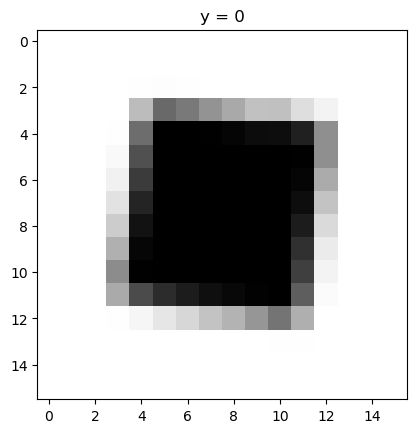

In [29]:
show_data(train_dataset[100])

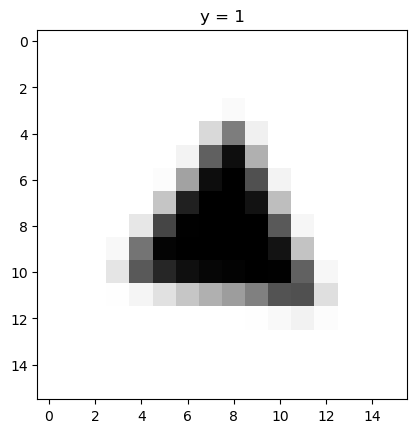

In [30]:
show_data(train_dataset[3000])

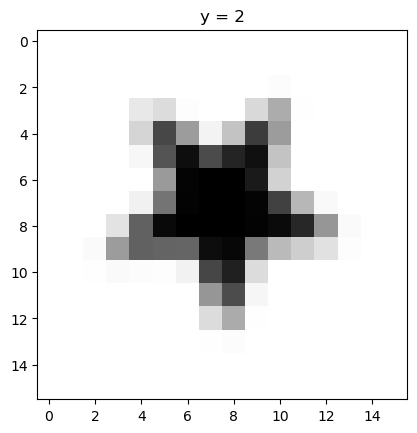

In [31]:
show_data(train_dataset[6000])

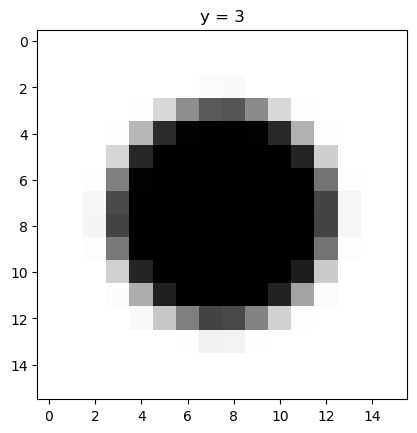

In [33]:
show_data(train_dataset[10000])

Creating a validation/test dataset by creating a <code>Dataset</code> object called <code>test_dataset</code>

In [34]:
test_dataset = Dataset(transform=transforms.Compose([transforms.Resize((16,16)),transforms.ToTensor()]),train=False)

<!--Empty Space for separating topics-->

<h1>CNN model building</h1>

In [39]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 4)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

Creating the model object using CNN class

In [40]:
model=CNN()

Plotting the model parameters for the kernels before training the kernels (random initialization)

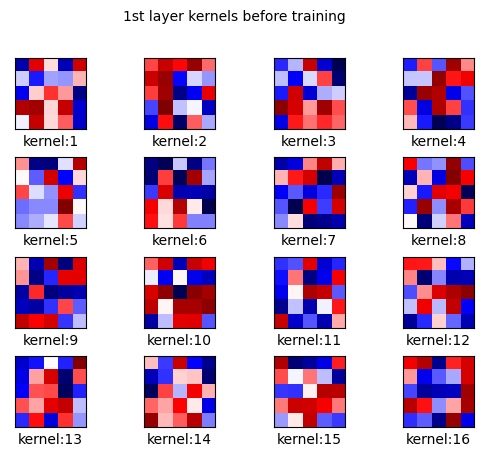

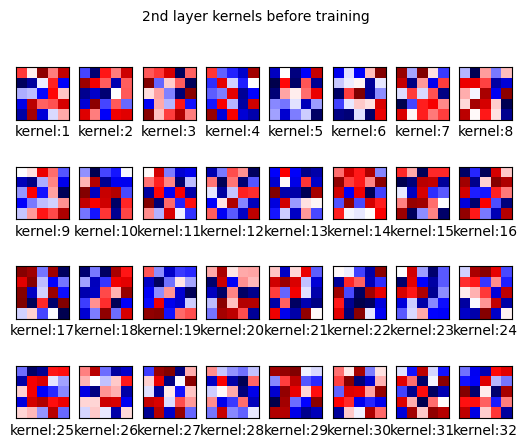

In [41]:
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

<h2>Setting parameters for training</h2>

In [44]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5000)
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=5000)

Training the model and determining the validation accuracy

In [46]:
n_epochs=120
cost_list=[]  
accuracy_list=[]
N_test=len(test_dataset)
start_time = time.time()
for epoch in range(n_epochs):
    COST=0
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        COST+=loss.data

    cost_list.append(COST)
    correct=0

    #perform a prediction on the validation  data
    for x_test, y_test in validation_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)

<!--Empty Space for separating topics-->

<h2>Results analysis</h2> 

Ploting the loss and accuracy on the validation data:

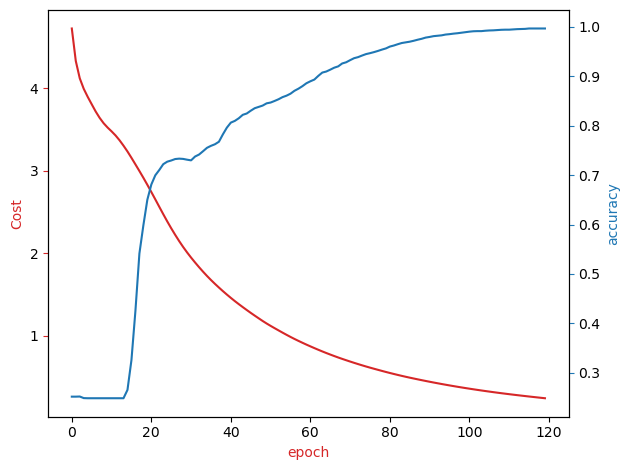

In [49]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.show()

Viewing the results of the parameters for the Convolutional layers 

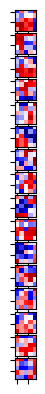

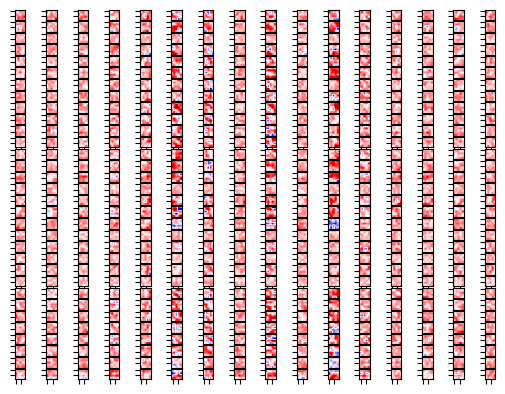

In [50]:
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Checking results for the following sample

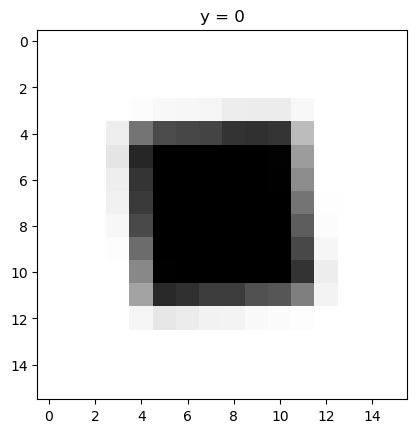

In [51]:
show_data(train_dataset[1])

Determining its activations

In [52]:
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plotting out the first set of activations 

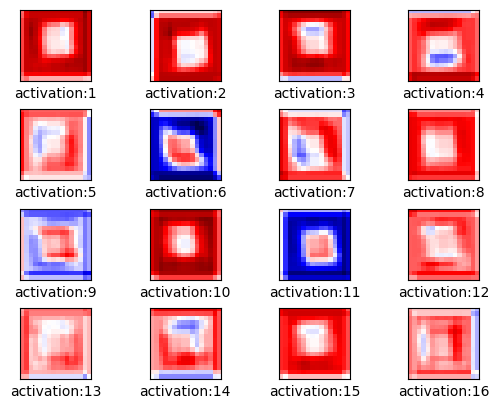

In [53]:
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

Plotting out the first set of ReLU activations 

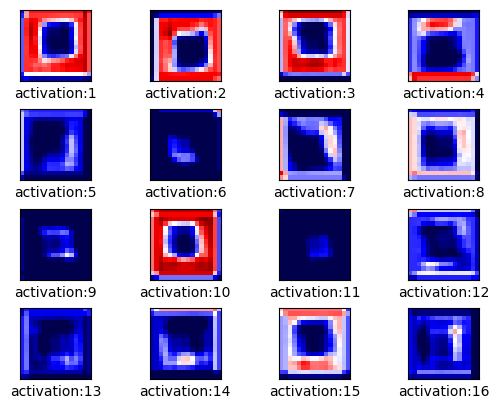

In [54]:
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

Plotting out the second set of activations

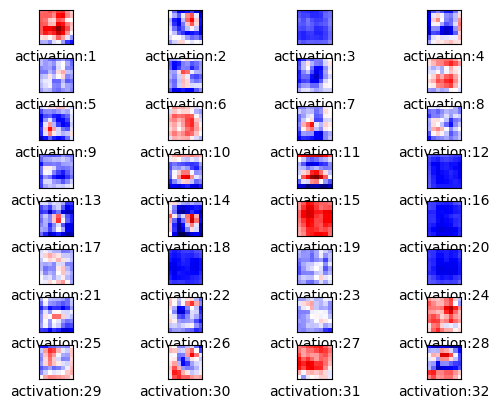

In [55]:
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

Plotting out the second set of ReLU activations

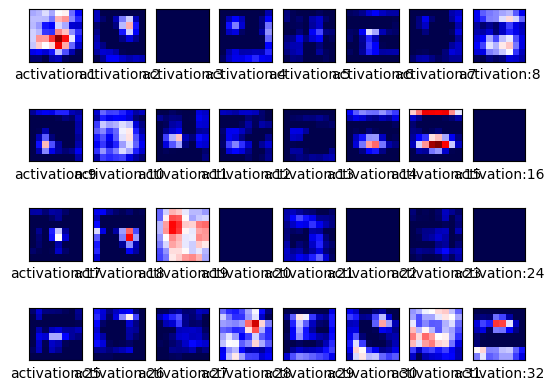

In [56]:
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

Checking results for the following sample

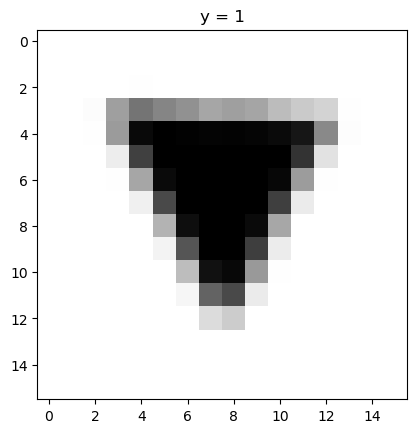

In [57]:
show_data(train_dataset[2999])

Determining its activations

In [58]:
out = model.activations(train_dataset[2999][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plotting out the first set of activations 

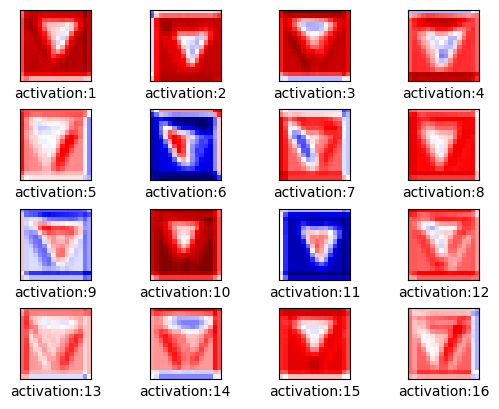

In [59]:
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

Plotting out the first set of ReLU activations 

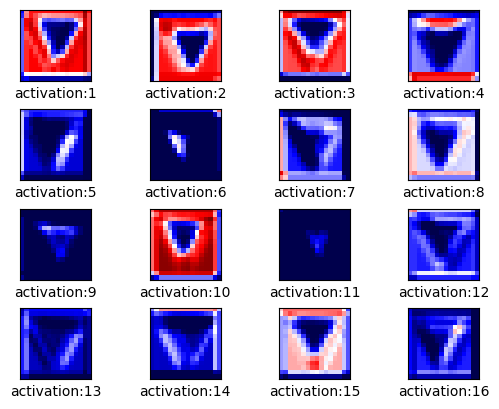

In [60]:
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

Plotting out the second set of activations

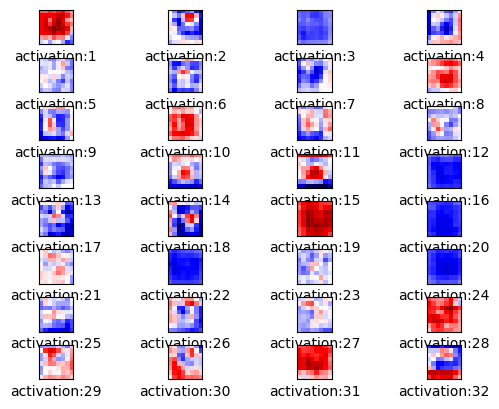

In [61]:
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

Plotting out the second set of ReLU activations

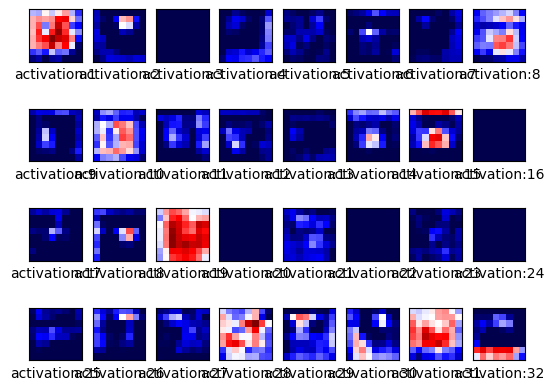

In [62]:
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

Plotting the first five mis-classified samples (squares misclassified as circles):

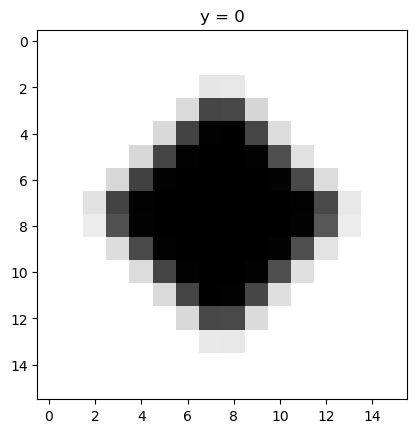

yhat:  tensor([3])


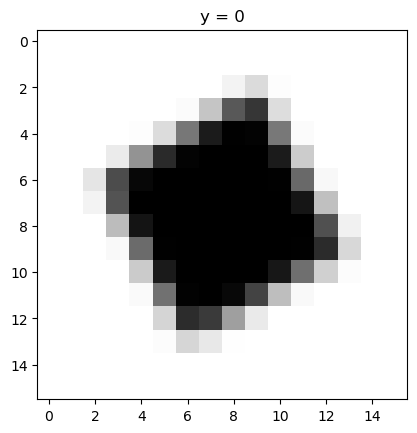

yhat:  tensor([3])


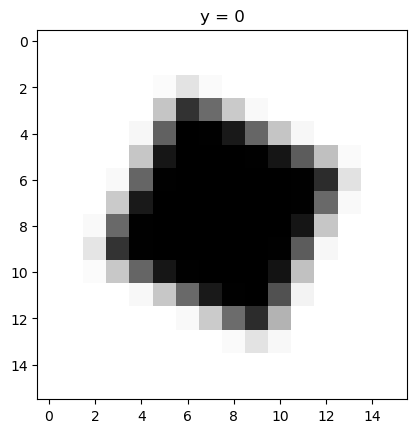

yhat:  tensor([3])


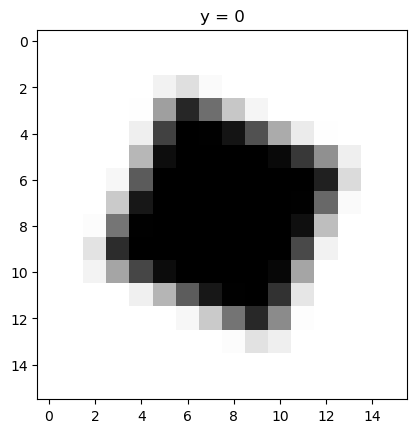

yhat:  tensor([3])


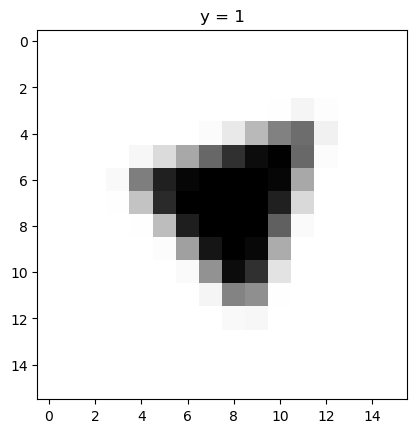

yhat:  tensor([2])


In [63]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  